<a href="https://colab.research.google.com/github/asdfasdf0311/Optimal_location_selection/blob/main/03_MCLP_%EC%9D%8D%EB%A9%B4%EB%8F%99%EB%B3%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 필요한 라이브러리

In [ ]:
pip install koreanize-matplotlib

In [ ]:
!pip install pandas numpy ortools

In [ ]:
pip install kneed

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
from ortools.linear_solver import pywraplp
from geopy.distance import geodesic
import folium
from tqdm import tqdm  # 진행 상황 표시용
from kneed import KneeLocator

In [ ]:
#데이터 경로 설정
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/2024BIGCON/MCLP/mclp_df.csv')

## 전처리

In [ ]:
# '인구수' 열에서 결측치(NaN)가 있는 행 제거
df = df.dropna(subset=['인구수'])
# '인구수'와 '관광객방문수' 열을 int형으로 변환
df['인구수'] = df['인구수'].astype(int)
df['관광객방문수'] = df['관광객방문수'].astype(int)
# '읍면동명'이 '지정면'인 행 삭제
df = df[df['읍면동명'] != '지정면']

## 가중치 적용 및 중요도 계산

In [ ]:
# 가중치 정의
weights = {
    '인구밀집도': 0.5993,
    '유동인구수': 0.1774,
    '관광객방문수': 0.1031,
    '버스승하차': 0.1203
}

# 정규화 함수 정의
def normalize(series):
    min_val = series.min()
    max_val = series.max()
    if max_val != min_val:
        return (series - min_val) / (max_val - min_val)
    else:
        return pd.Series([0.5]*len(series), index=series.index)

# 각 열을 정규화 (0~1 범위로 스케일링)
df['인구수_norm'] = normalize(df['인구수'])
df['총_유동인구수_norm'] = normalize(df['총_유동인구수'])
df['관광객방문수_norm'] = normalize(df['관광객방문수'])
df['승하차수_norm'] = normalize(df['승하차수'])

# 중요도 계산
df['종합중요도'] = (
    weights['인구밀집도'] * df['인구수_norm'] +
    weights['유동인구수'] * df['총_유동인구수_norm'] +
    weights['관광객방문수'] * df['관광객방문수_norm'] +
    weights['버스승하차'] * df['승하차수_norm']
)

# 중요도 기준으로 정렬
df = df.sort_values(by='종합중요도', ascending=False).reset_index(drop=True)

print(df[['버스정류장명', '종합중요도']])

         버스정류장명     종합중요도
0         롯데시네마  0.909634
1       한신2차아파트  0.890641
2       청솔3차아파트  0.889538
3         현진에버빌  0.887455
4          판부농협  0.886958
..          ...       ...
194        상지여중  0.158301
195       덕산아파트  0.158190
196         반곡교  0.157170
197  사랑간호데이케어센터  0.156784
198         원마트  0.156770

[199 rows x 2 columns]


# 읍면동별 최적의 정류장 개수 구하기 (각 읍면동별로 1개씩은 선택이 되도록)



In [ ]:
# 가중치 정의
weights = {
    '인구밀집도': 0.5993,
    '유동인구수': 0.1774,
    '관광객방문수': 0.1031,
    '버스승하차': 0.1203
}

# 정규화 함수 정의
def normalize(series):
    min_val = series.min()
    max_val = series.max()
    if max_val != min_val:
        return (series - min_val) / (max_val - min_val)
    else:
        # 모든 값이 동일한 경우, 중간값으로 설정
        return pd.Series([0.5]*len(series), index=series.index)

# 각 열을 정규화 (0~1 범위로 스케일링)
df['인구밀집도_norm'] = normalize(df['인구밀집도'])
df['총_유동인구수_norm'] = normalize(df['총_유동인구수'])
df['관광객방문수_norm'] = normalize(df['관광객방문수'])
df['승하차수_norm'] = normalize(df['승하차수'])

# 중요도 계산
df['종합중요도'] = (
    weights['인구밀집도'] * df['인구밀집도_norm'] +
    weights['유동인구수'] * df['총_유동인구수_norm'] +
    weights['관광객방문수'] * df['관광객방문수_norm'] +
    weights['버스승하차'] * df['승하차수_norm']
)

# 중요도 기준으로 정렬
df = df.sort_values(by='종합중요도', ascending=False).reset_index(drop=True)

# 중요도 확인
print(df[['버스정류장명', '종합중요도', '읍면동명']])


        버스정류장명     종합중요도   읍면동명
0        롯데시네마  0.760914    단구동
1      한신2차아파트  0.741921    단구동
2      청솔3차아파트  0.740818    단구동
3        현진에버빌  0.738735    단구동
4         판부농협  0.738239    단구동
..         ...       ...    ...
194     섭재마을회관  0.161108  반곡관설동
195  반곡관설동주민센터  0.161108  반곡관설동
196    관설동 차고지  0.161094  반곡관설동
197    삼보골마을회관  0.161094  반곡관설동
198        입춘내  0.161094  반곡관설동

[199 rows x 3 columns]


## 거리 계산 및 커버리지 매트릭스 생성

In [ ]:
# 커버리지 반경 설정 (단위: 미터)
coverage_radius = 200  # 200

# 최소 거리 설정 (커버리지 영역이 겹치지 않도록)
min_distance = 2 * coverage_radius  # 400

# 총 정류장 수
num_stations = len(df)

# 모든 정류장 간 거리 계산
distance_matrix = np.zeros((num_stations, num_stations))

for i in range(num_stations):
    for j in range(num_stations):
        if i == j:
            distance_matrix[i][j] = 0
        else:
            coord1 = (df.loc[i, '위도'], df.loc[i, '경도'])
            coord2 = (df.loc[j, '위도'], df.loc[j, '경도'])
            distance = geodesic(coord1, coord2).meters
            distance_matrix[i][j] = distance

# 커버리지 매트릭스 생성 (1: 커버, 0: 미커버)
coverage_matrix = (distance_matrix <= coverage_radius).astype(int)

# 겹치는 커버리지 방지: 정류장 간 최소 거리 유지
# 겹칠 수 있는 정류장 쌍 찾기 (거리가 min_distance 미만)
overlap_pairs = []
for i in range(num_stations):
    for j in range(i+1, num_stations):
        if distance_matrix[i][j] < min_distance:
            overlap_pairs.append((i, j))

print(f"Total overlap pairs: {len(overlap_pairs)}")


Total overlap pairs: 434


* 커버리지 반경 설정: 각 정류장이 커버할 수 있는 거리 범위를 설정합니다. 여기서는 500미터를 사용했습니다.
* 최소 거리 설정: 커버리지 영역이 겹치지 않도록, 정류장 간 최소 거리를 1000미터로 설정합니다.
* 거리 계산: 모든 정류장 간의 거리를 계산하여 거리 매트릭스를 생성합니다.
* 커버리지 매트릭스 생성: 거리 매트릭스를 기반으로 각 정류장이 다른 정류장을 커버할 수 있는지 여부를 1과 0으로 표시하는 매트릭스를 생성합니다.
* 겹치는 커버리지 방지: 정류장 간 거리가 최소 거리 미만인 쌍을 찾아 리스트로 저장합니다. 이는 나중에 최적화 모델에서 제약 조건으로 사용됩니다.

## **전역 MCLP 모델링 및 해결 (총 정류장 수 22개, 읍면동별 최소 1개, 커버리지 반경 비중첩)**

In [ ]:
# OR-Tools 선형 프로그래밍 솔버 초기화
solver = pywraplp.Solver.CreateSolver('SCIP')

if not solver:
    raise Exception("Solver not found.")

# 변수: 각 정류장이 선택되었는지 여부 (0 또는 1)
x = [solver.IntVar(0, 1, f'x_{i}') for i in range(num_stations)]

# 목적 함수: 커버되는 수요의 최대화
objective = solver.Objective()
for j in range(num_stations):
    for i in range(num_stations):
        if coverage_matrix[i][j]:
            objective.SetCoefficient(x[i], df.loc[j, '종합중요도'])
objective.SetMaximization()

# 제약 조건 1: 선택할 정류장 수는 22개
solver.Add(solver.Sum(x) == 22)

# 제약 조건 2: 커버리지 영역 겹치지 않도록 최소 거리 유지
for (i, j) in overlap_pairs:
    solver.Add(x[i] + x[j] <= 1)

# 제약 조건 3: 각 읍면동별로 최소 1개의 정류장 선택
eupmyeondong_list = df['읍면동명'].unique()
for eupmyeondong in eupmyeondong_list:
    indices = df[df['읍면동명'] == eupmyeondong].index.tolist()
    if len(indices) == 0:
        continue  # 해당 읍면동에 정류장이 없는 경우 건너뜀
    solver.Add(solver.Sum([x[i] for i in indices]) >= 1)

# 문제 해결
status = solver.Solve()

if status == pywraplp.Solver.OPTIMAL:
    print(f'Optimal solution found with total coverage: {objective.Value():.4f}')
    selected_stations = []
    for i in range(num_stations):
        if x[i].solution_value() > 0.5:
            selected_stations.append(df.loc[i, '버스정류장명'])
            print(f'선택된 정류장 {i}: {df.loc[i, "버스정류장명"]}')
else:
    print("No optimal solution found.")


Optimal solution found with total coverage: 14.2461
선택된 정류장 4: 판부농협
선택된 정류장 11: 현진에버빌아파트
선택된 정류장 18: 남원주초등학교
선택된 정류장 19: 남원주중학교입구
선택된 정류장 21: 청솔4차아파트
선택된 정류장 23: 원주중학교
선택된 정류장 26: 두산아파트
선택된 정류장 27: 단구동주민센터
선택된 정류장 31: 통일사거리
선택된 정류장 32: KT강원본부
선택된 정류장 33: 늘품사거리
선택된 정류장 37: 한신1차아파트
선택된 정류장 39: 성지병원
선택된 정류장 43: 대성현대아파트
선택된 정류장 45: 원주고 동문회관
선택된 정류장 50: 원마트
선택된 정류장 54: 종합운동장
선택된 정류장 57: 치악체육관
선택된 정류장 67: 동보노빌리티(포스코APT)
선택된 정류장 74: 시외.고속버스터미널
선택된 정류장 75: 원주역
선택된 정류장 141: 관설동 종점


## 결과 시각화 (선택된 정류장 및 커버리지)

In [ ]:
# 지도 생성 함수 정의 (MarkerCluster 포함)
from folium.plugins import MarkerCluster

def create_map_global(df, selected_stations, coverage_radius=500, save_path='selected_bus_stations_global.html'):
    # 지도 중심 설정
    center_lat = df['위도'].mean()
    center_lon = df['경도'].mean()
    m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

    # MarkerCluster 추가
    marker_cluster = MarkerCluster().add_to(m)

    # 모든 정류장 표시 (파란색 마커)
    for idx, row in df.iterrows():
        folium.CircleMarker(
            location=[row['위도'], row['경도']],
            radius=5,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6,
            popup=row['버스정류장명']
        ).add_to(m)

    # 선택된 정류장 표시 (빨간색 마커) 및 커버리지 반경 표시 (동그라미)
    for station in selected_stations:
        row = df[df['버스정류장명'] == station].iloc[0]

        # 선택된 정류장 마커 (빨간색)
#        folium.Marker(
#            location=[row['위도'], row['경도']],
#            popup=f"{row['버스정류장명']}<br>종합중요도: {row['종합중요도']:.4f}",
#            icon=folium.Icon(color='red', icon='info-sign')
#        ).add_to(m)

        # 커버리지 반경 표시 (동그라미)
        folium.Circle(
            location=[row['위도'], row['경도']],
            radius=coverage_radius,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.1
        ).add_to(m)

    # 지도 저장
    m.save(save_path)
    return m

# 선택된 정류장 목록 확인
print(f'\n총 22개의 선택된 정류장:')
print(selected_stations)

# 지도 생성
map_obj_global = create_map_global(df, selected_stations, coverage_radius=500, save_path='selected_bus_stations_global.html')

# 지도 표시 (Jupyter Notebook에서)
display(map_obj_global)

print("\n선택된 정류장이 표시된 지도가 'selected_bus_stations_global.html'로 저장되었습니다.")



총 22개의 선택된 정류장:
['판부농협', '현진에버빌아파트', '남원주초등학교', '남원주중학교입구', '청솔4차아파트', '원주중학교', '두산아파트', '단구동주민센터', '통일사거리', 'KT강원본부', '늘품사거리', '한신1차아파트', '성지병원', '대성현대아파트', '원주고 동문회관', '원마트', '종합운동장', '치악체육관', '동보노빌리티(포스코APT)', '시외.고속버스터미널', '원주역', '관설동 종점']



선택된 정류장이 표시된 지도가 'selected_bus_stations_global.html'로 저장되었습니다.


# 읍면동별 최적의 정류장 개수 구하기 (각 읍면동별로 2개씩은 선택이 되도록)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/2024BIGCON/MCLP/mclp_df.csv')

# '인구수' 열에서 결측치(NaN)가 있는 행 제거
df = df.dropna(subset=['인구수'])
# '인구수'와 '관광객방문수' 열을 int형으로 변환
df['인구수'] = df['인구수'].astype(int)
df['관광객방문수'] = df['관광객방문수'].astype(int)
# '읍면동명'이 '지정면'인 행 삭제
df = df[df['읍면동명'] != '지정면']


# 필요한 열 선택
df = df[['버스정류장명', '위도', '경도', '승하차수', '총_유동인구수', '관광객방문수', '인구밀집도', '읍면동명']]

# 가중치 정의
weights = {
    '인구밀집도': 0.5993,
    '유동인구수': 0.1774,
    '관광객방문수': 0.1031,
    '버스승하차': 0.1203
}

# 정규화 함수 정의
def normalize(series):
    min_val = series.min()
    max_val = series.max()
    if max_val != min_val:
        return (series - min_val) / (max_val - min_val)
    else:
        return pd.Series([0.5]*len(series), index=series.index)

# 각 열을 정규화 (0~1 범위로 스케일링)
df['인구밀집도_norm'] = normalize(df['인구밀집도'])
df['총_유동인구수_norm'] = normalize(df['총_유동인구수'])
df['관광객방문수_norm'] = normalize(df['관광객방문수'])
df['승하차수_norm'] = normalize(df['승하차수'])

# 중요도 계산
df['종합중요도'] = (
    weights['인구밀집도'] * df['인구밀집도_norm'] +
    weights['유동인구수'] * df['총_유동인구수_norm'] +
    weights['관광객방문수'] * df['관광객방문수_norm'] +
    weights['버스승하차'] * df['승하차수_norm']
)

# 중요도 기준으로 정렬
df = df.sort_values(by='종합중요도', ascending=False).reset_index(drop=True)

# 커버리지 반경 설정 (단위: 미터)
coverage_radius = 500  # 예: 500미터

# 최소 거리 설정 (커버리지 영역이 겹치지 않도록)
min_distance = 2 * coverage_radius  # 1000미터

# 총 정류장 수
num_stations = len(df)

# 모든 정류장 간 거리 계산
distance_matrix = np.zeros((num_stations, num_stations))

for i in range(num_stations):
    for j in range(num_stations):
        if i == j:
            distance_matrix[i][j] = 0
        else:
            coord1 = (df.loc[i, '위도'], df.loc[i, '경도'])
            coord2 = (df.loc[j, '위도'], df.loc[j, '경도'])
            distance = geodesic(coord1, coord2).meters
            distance_matrix[i][j] = distance

# 커버리지 매트릭스 생성 (1: 커버, 0: 미커버)
coverage_matrix = (distance_matrix <= coverage_radius).astype(int)

# 겹치는 커버리지 방지: 정류장 간 최소 거리 유지
# 겹칠 수 있는 정류장 쌍 찾기 (거리가 min_distance 미만)
overlap_pairs = []
for i in range(num_stations):
    for j in range(i+1, num_stations):
        if distance_matrix[i][j] < min_distance:
            overlap_pairs.append((i, j))

print(f"Total overlap pairs: {len(overlap_pairs)}")

# 전역 MCLP 모델링 및 해결 (총 정류장 수 22개, 읍면동별 최소 2개, 커버리지 반경 비중첩)
solver = pywraplp.Solver.CreateSolver('SCIP')

if not solver:
    raise Exception("Solver not found.")

# 변수: 각 정류장이 선택되었는지 여부 (0 또는 1)
x = [solver.IntVar(0, 1, f'x_{i}') for i in range(num_stations)]

# 목적 함수: 커버되는 수요의 최대화
objective = solver.Objective()
for j in range(num_stations):
    for i in range(num_stations):
        if coverage_matrix[i][j]:
            objective.SetCoefficient(x[i], df.loc[j, '종합중요도'])
objective.SetMaximization()

# 제약 조건 1: 선택할 정류장 수는 22개
solver.Add(solver.Sum(x) == 22)

# 제약 조건 2: 커버리지 영역 겹치지 않도록 최소 거리 유지
for (i, j) in overlap_pairs:
    solver.Add(x[i] + x[j] <= 1)

# 제약 조건 3: 각 읍면동별로 최소 2개의 정류장 선택
eupmyeondong_list = df['읍면동명'].unique()
for eupmyeondong in eupmyeondong_list:
    indices = df[df['읍면동명'] == eupmyeondong].index.tolist()
    if len(indices) == 0:
        continue  # 해당 읍면동에 정류장이 없는 경우 건너뜀
    solver.Add(solver.Sum([x[i] for i in indices]) >= 2)

# 문제 해결
status = solver.Solve()

if status == pywraplp.Solver.OPTIMAL:
    print(f'Optimal solution found with total coverage: {objective.Value():.4f}')
    selected_stations = []
    for i in range(num_stations):
        if x[i].solution_value() > 0.5:
            selected_stations.append(df.loc[i, '버스정류장명'])
            print(f'선택된 정류장 {i}: {df.loc[i, "버스정류장명"]}')
else:
    print("No optimal solution found.")


Total overlap pairs: 2137
Optimal solution found with total coverage: 7.8539
선택된 정류장 14: 단구초등학교
선택된 정류장 17: 성일아파트
선택된 정류장 30: 통일사거리
선택된 정류장 38: 원주의료원
선택된 정류장 45: 원주고 동문회관
선택된 정류장 61: 동보노빌리티입구
선택된 정류장 64: 원예하나로마트
선택된 정류장 80: 이마트
선택된 정류장 83: 봉바위
선택된 정류장 93: 휴먼시아6차(원주어시장)
선택된 정류장 100: 은행정마을(시내방면)
선택된 정류장 118: 코오롱아파트
선택된 정류장 126: 장미아파트
선택된 정류장 129: 단계이안아파트
선택된 정류장 136: 사랑의집
선택된 정류장 141: 관설동 종점
선택된 정류장 144: 건강보험심사평가원
선택된 정류장 154: 미래삼거리(센트럴파크6)
선택된 정류장 178: 영서고
선택된 정류장 181: 부영8단지
선택된 정류장 188: 원주소방서
선택된 정류장 196: 삼보골마을회관


## 결과 시각화

In [ ]:
# 지도 생성 함수 정의 (MarkerCluster 포함)
from folium.plugins import MarkerCluster

def create_map_global(df, selected_stations, coverage_radius=500, save_path='selected_bus_stations_global.html'):
    # 지도 중심 설정
    center_lat = df['위도'].mean()
    center_lon = df['경도'].mean()
    m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

    # MarkerCluster 추가
    marker_cluster = MarkerCluster().add_to(m)

    # 모든 정류장 표시 (파란색 마커)
    for idx, row in df.iterrows():
        folium.CircleMarker(
            location=[row['위도'], row['경도']],
            radius=5,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6,
            popup=row['버스정류장명']
        ).add_to(m)

    # 선택된 정류장 표시 (빨간색 마커) 및 커버리지 반경 표시 (동그라미)
    for station in selected_stations:
        row = df[df['버스정류장명'] == station].iloc[0]

        # 선택된 정류장 마커 (빨간색)
#        folium.Marker(
#            location=[row['위도'], row['경도']],
#            popup=f"{row['버스정류장명']}<br>종합중요도: {row['종합중요도']:.4f}",
#            icon=folium.Icon(color='red', icon='info-sign')
#        ).add_to(m)

        # 커버리지 반경 표시 (동그라미)
        folium.Circle(
            location=[row['위도'], row['경도']],
            radius=coverage_radius,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.1
        ).add_to(m)

    # 지도 저장
    m.save(save_path)
    return m

# 선택된 정류장 목록 확인
print(f'\n총 22개의 선택된 정류장:')
print(selected_stations)

# 지도 생성
map_obj_global = create_map_global(df, selected_stations, coverage_radius=500, save_path='selected_bus_stations_global.html')

# 지도 표시 (Jupyter Notebook에서)
display(map_obj_global)

print("\n선택된 정류장이 표시된 지도가 'selected_bus_stations_global.html'로 저장되었습니다.")



총 22개의 선택된 정류장:
['단구초등학교', '성일아파트', '통일사거리', '원주의료원', '원주고 동문회관', '동보노빌리티입구', '원예하나로마트', '이마트', '봉바위', '휴먼시아6차(원주어시장)', '은행정마을(시내방면)', '코오롱아파트', '장미아파트', '단계이안아파트', '사랑의집', '관설동 종점', '건강보험심사평가원', '미래삼거리(센트럴파크6)', '영서고', '부영8단지', '원주소방서', '삼보골마을회관']



선택된 정류장이 표시된 지도가 'selected_bus_stations_global.html'로 저장되었습니다.


# 일단 읍면동별로 나눠둔거

In [ ]:
df['읍면동명'].value_counts()

,count
읍면동명,
반곡관설동,58
단구동,37
단계동,36
무실동,31
명륜동,23
개운동,14


In [ ]:
df_명륜동 = df[df['읍면동명'] == '명륜동']
df_개운동 = df[df['읍면동명'] == '개운동']
df_단계동 = df[df['읍면동명'] == '단계동']
df_단구동 = df[df['읍면동명'] == '단구동']
df_반곡관설동 = df[df['읍면동명'] == '반곡관설동']
df_지정면 = df[df['읍면동명'] == '지정면']
df_무실동 = df[df['읍면동명'] == '무실동']

## 함수

In [ ]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp

# 가중치 정의
weights = {
    '인구밀집도': 0.5993,
    '유동인구수': 0.1774,
    '관광객방문수': 0.1031,
    '버스승하차': 0.1203
}

# 정규화 함수 정의
def normalize(series):
    min_val = series.min()
    max_val = series.max()
    if max_val != min_val:
        return (series - min_val) / (max_val - min_val)
    else:
        return pd.Series([0.5]*len(series), index=series.index)

# 최적의 버스 정류장을 선택하고 커버리지 변화를 시각화하는 함수
def optimize_bus_stops(df, coverage_radius=500, min_distance=1000, facility_range=(1, 10)):
    # 각 열을 정규화
    df['인구밀집도_norm'] = normalize(df['인구밀집도'])
    df['총_유동인구수_norm'] = normalize(df['총_유동인구수'])
    df['관광객방문수_norm'] = normalize(df['관광객방문수'])
    df['승하차수_norm'] = normalize(df['승하차수'])

    # 중요도 계산
    df['종합중요도'] = (
        weights['인구밀집도'] * df['인구밀집도_norm'] +
        weights['유동인구수'] * df['총_유동인구수_norm'] +
        weights['관광객방문수'] * df['관광객방문수_norm'] +
        weights['버스승하차'] * df['승하차수_norm']
    )

    # 중요도 기준으로 정렬
    df = df.sort_values(by='종합중요도', ascending=False).reset_index(drop=True)

    # 모든 정류장 간 거리 계산
    num_stations = len(df)
    distance_matrix = np.zeros((num_stations, num_stations))

    for i in range(num_stations):
        for j in range(num_stations):
            if i == j:
                distance_matrix[i][j] = 0
            else:
                coord1 = (df.loc[i, '위도'], df.loc[j, '경도'])
                coord2 = (df.loc[j, '위도'], df.loc[j, '경도'])
                distance = geodesic(coord1, coord2).meters
                distance_matrix[i][j] = distance

    # 커버리지 매트릭스 생성
    coverage_matrix = (distance_matrix <= coverage_radius).astype(int)

    # 겹치는 커버리지 방지
    overlap_pairs = []
    for i in range(num_stations):
        for j in range(i+1, num_stations):
            if distance_matrix[i][j] < min_distance:
                overlap_pairs.append((i, j))

    # 최적의 정류장 개수를 찾기 위한 범위 설정
    coverage_values = []
    selected_stations_list = []

    for num in range(facility_range[0], facility_range[1] + 1):
        # OR-Tools 선형 프로그래밍 솔버 초기화
        solver = pywraplp.Solver.CreateSolver('SCIP')
        if not solver:
            raise Exception("Solver not found.")

        # 변수 정의
        x = [solver.IntVar(0, 1, f'x_{i}') for i in range(num_stations)]

        # 목적 함수: 커버되는 수요의 최대화
        objective = solver.Objective()
        for j in range(num_stations):
            for i in range(num_stations):
                if coverage_matrix[i][j]:
                    objective.SetCoefficient(x[i], df.loc[j, '종합중요도'])
        objective.SetMaximization()

        # 제약 조건 1: 선택할 정류장 수는 num
        solver.Add(solver.Sum(x) == num)

        # 제약 조건 2: 커버리지 영역 겹치지 않도록 최소 거리 유지
        for (i, j) in overlap_pairs:
            solver.Add(x[i] + x[j] <= 1)

        # 문제 해결
        status = solver.Solve()

        if status == pywraplp.Solver.OPTIMAL:
            coverage = objective.Value()
            coverage_values.append(coverage)
            current_selected_stations = []
            for i in range(num_stations):
                if x[i].solution_value() > 0.5:
                    current_selected_stations.append(df.loc[i, '버스정류장명'])
            selected_stations_list.append(current_selected_stations)
            print(f'Bus Stops: {num}, Total Coverage: {coverage:.4f}')
        else:
            coverage_values.append(0)
            selected_stations_list.append([])
            print(f'Bus Stops: {num}, No optimal solution found.')

    # 커버리지 변화 시각화
    plt.figure(figsize=(10,6))
    plt.plot(range(facility_range[0], facility_range[1] + 1), coverage_values, marker='o', label='총 커버리지')
    plt.xlabel('버스 정류장 개수')
    plt.ylabel('총 커버리지')
    plt.title('버스 정류장 개수에 따른 총 커버리지 변화')
    plt.grid(True)

    # 기울기(증가율) 계산
    coverage_diffs = np.diff(coverage_values)
    slope = coverage_diffs / 1  # 버스 정류장 개수 간 간격이 1이므로 단순히 차이

    # 기울기 시각화 (같은 x 축에, shifted x)
    plt.plot(range(facility_range[0], facility_range[1]), coverage_diffs, marker='s', linestyle='--', color='red', label='커버리지 증가율')
    plt.legend()
    plt.show()

    # 기울기 출력
    for num, diff in zip(range(facility_range[0], facility_range[1]), coverage_diffs):
        print(f'Bus Stops: {num} -> {num+1}, Coverage Increase: {diff:.4f}')


    #ㅇㅇㅇ
    print(selected_stations_list)

# 함수 호출 예시
# optimize_bus_stops(df, coverage_radius=500, min_distance=1000, facility_range=(1, 10))


### 명륜동

Bus Stops: 1, Total Coverage: 0.4483
Bus Stops: 2, Total Coverage: 0.8957
Bus Stops: 3, Total Coverage: 1.3417


<ipython-input-19-c325403d0c6b>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['인구밀집도_norm'] = normalize(df['인구밀집도'])
<ipython-input-19-c325403d0c6b>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['총_유동인구수_norm'] = normalize(df['총_유동인구수'])
<ipython-input-19-c325403d0c6b>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

Bus Stops: 4, Total Coverage: 1.7846
Bus Stops: 5, Total Coverage: 2.2206
Bus Stops: 6, No optimal solution found.
Bus Stops: 7, No optimal solution found.
Bus Stops: 8, No optimal solution found.
Bus Stops: 9, No optimal solution found.
Bus Stops: 10, No optimal solution found.


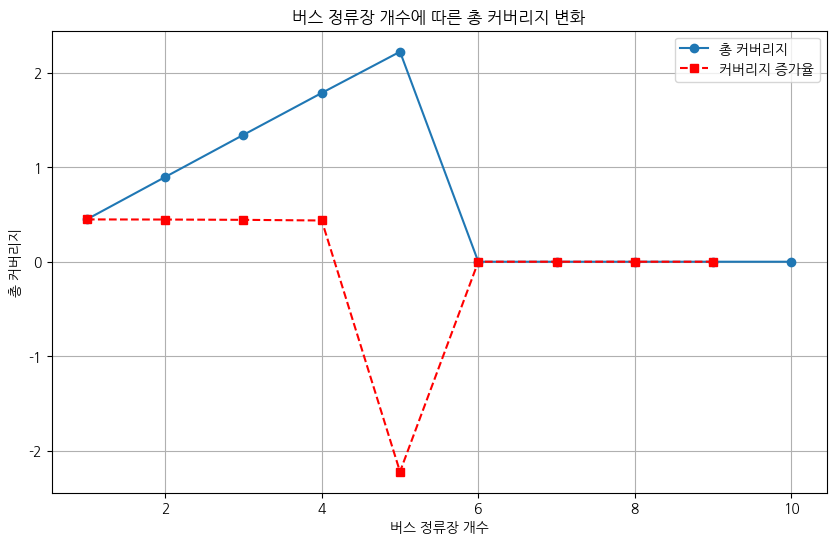

Bus Stops: 1 -> 2, Coverage Increase: 0.4473
Bus Stops: 2 -> 3, Coverage Increase: 0.4460
Bus Stops: 3 -> 4, Coverage Increase: 0.4429
Bus Stops: 4 -> 5, Coverage Increase: 0.4360
Bus Stops: 5 -> 6, Coverage Increase: -2.2206
Bus Stops: 6 -> 7, Coverage Increase: 0.0000
Bus Stops: 7 -> 8, Coverage Increase: 0.0000
Bus Stops: 8 -> 9, Coverage Increase: 0.0000
Bus Stops: 9 -> 10, Coverage Increase: 0.0000
[['남원로남부시장'], ['남원로남부시장', '치악예술관'], ['남원로남부시장', '종합운동장', '동보노빌리티(포스코APT)'], ['남원로남부시장', '치악예술관', '원주시시설관리공단', '동보노빌리티정문'], ['남원로남부시장', '향교입구', '원주시시설관리공단', '동보노빌리티입구', '행운아파트앞'], [], [], [], [], []]


In [ ]:
optimize_bus_stops(df_명륜동, coverage_radius=200, min_distance=400, facility_range=(1, 10))

### 개운동

Bus Stops: 1, Total Coverage: 0.5602
Bus Stops: 2, Total Coverage: 1.0280
Bus Stops: 3, Total Coverage: 1.4695
Bus Stops: 4, Total Coverage: 1.9094
Bus Stops: 5, No optimal solution found.
Bus Stops: 6, No optimal solution found.
Bus Stops: 7, No optimal solution found.
Bus Stops: 8, No optimal solution found.
Bus Stops: 9, No optimal solution found.
Bus Stops: 10, No optimal solution found.


<ipython-input-19-c325403d0c6b>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['인구밀집도_norm'] = normalize(df['인구밀집도'])
<ipython-input-19-c325403d0c6b>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['총_유동인구수_norm'] = normalize(df['총_유동인구수'])
<ipython-input-19-c325403d0c6b>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

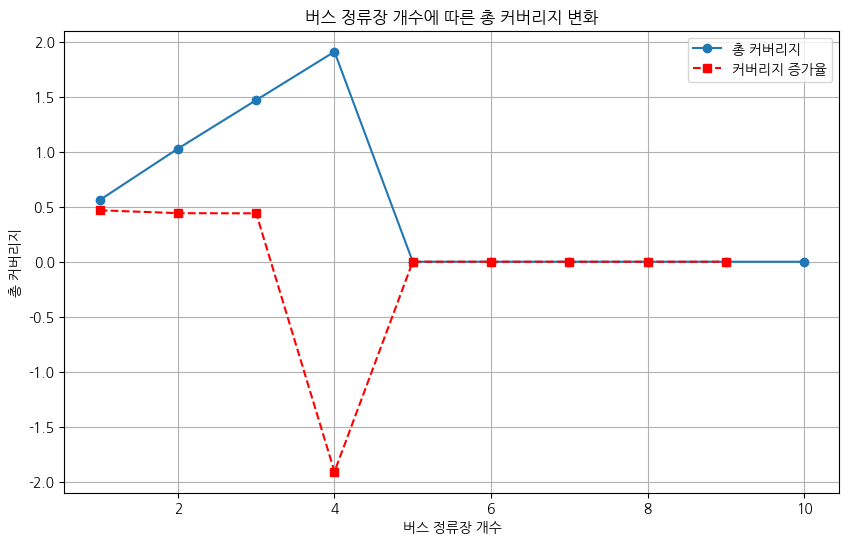

Bus Stops: 1 -> 2, Coverage Increase: 0.4678
Bus Stops: 2 -> 3, Coverage Increase: 0.4415
Bus Stops: 3 -> 4, Coverage Increase: 0.4399
Bus Stops: 4 -> 5, Coverage Increase: -1.9094
Bus Stops: 5 -> 6, Coverage Increase: 0.0000
Bus Stops: 6 -> 7, Coverage Increase: 0.0000
Bus Stops: 7 -> 8, Coverage Increase: 0.0000
Bus Stops: 8 -> 9, Coverage Increase: 0.0000
Bus Stops: 9 -> 10, Coverage Increase: 0.0000
[['한신1차아파트'], ['한신1차아파트', '성지병원'], ['한신1차아파트', '성지병원', '반곡교'], ['한신1차아파트', '성지병원', '젊음의광장사거리', '대성현대아파트'], [], [], [], [], [], []]


In [ ]:
optimize_bus_stops(df_개운동, coverage_radius=200, min_distance=400, facility_range=(1, 10))

### 단계동

<ipython-input-19-c325403d0c6b>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['인구밀집도_norm'] = normalize(df['인구밀집도'])
<ipython-input-19-c325403d0c6b>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['총_유동인구수_norm'] = normalize(df['총_유동인구수'])
<ipython-input-19-c325403d0c6b>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

Bus Stops: 1, Total Coverage: 0.4417
Bus Stops: 2, Total Coverage: 0.8823
Bus Stops: 3, Total Coverage: 1.3227
Bus Stops: 4, Total Coverage: 1.7629
Bus Stops: 5, Total Coverage: 2.2028
Bus Stops: 6, Total Coverage: 2.6426
Bus Stops: 7, No optimal solution found.
Bus Stops: 8, No optimal solution found.
Bus Stops: 9, No optimal solution found.
Bus Stops: 10, No optimal solution found.


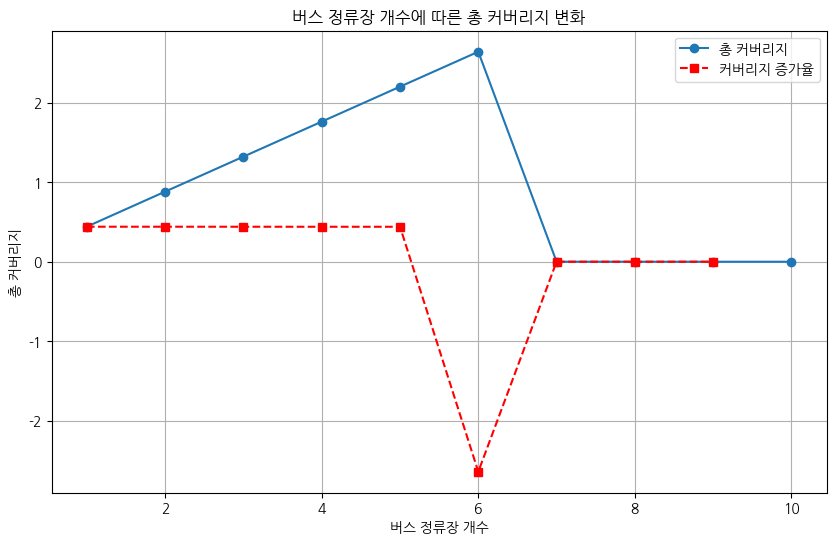

Bus Stops: 1 -> 2, Coverage Increase: 0.4406
Bus Stops: 2 -> 3, Coverage Increase: 0.4404
Bus Stops: 3 -> 4, Coverage Increase: 0.4402
Bus Stops: 4 -> 5, Coverage Increase: 0.4399
Bus Stops: 5 -> 6, Coverage Increase: 0.4398
Bus Stops: 6 -> 7, Coverage Increase: -2.6426
Bus Stops: 7 -> 8, Coverage Increase: 0.0000
Bus Stops: 8 -> 9, Coverage Increase: 0.0000
Bus Stops: 9 -> 10, Coverage Increase: 0.0000
[['코오롱아파트정문'], ['단계삼익아파트', '코오롱아파트'], ['코오롱아파트정문', '서원주유소', '봉화산벨라시티3차아파트'], ['금불사거리', '단계아파트', '단계이안아파트', '봉화산벨라시티3차아파트'], ['코오롱아파트정문', '단계이안아파트', '백간공원', '봉화산벨라시티2차아파트', '평원중학교'], ['코오롱아파트정문', '단계이안아파트', '백간공원', '롯데아파트', '평원중학교', '단계현대아파트'], [], [], [], []]


In [ ]:
optimize_bus_stops(df_단계동, coverage_radius=200, min_distance=400, facility_range=(1, 10))

### 단구동

<ipython-input-19-c325403d0c6b>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['인구밀집도_norm'] = normalize(df['인구밀집도'])
<ipython-input-19-c325403d0c6b>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['총_유동인구수_norm'] = normalize(df['총_유동인구수'])
<ipython-input-19-c325403d0c6b>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

Bus Stops: 1, Total Coverage: 0.4431
Bus Stops: 2, Total Coverage: 0.8854
Bus Stops: 3, Total Coverage: 1.3270
Bus Stops: 4, Total Coverage: 1.7679
Bus Stops: 5, Total Coverage: 2.2078
Bus Stops: 6, No optimal solution found.
Bus Stops: 7, No optimal solution found.
Bus Stops: 8, No optimal solution found.
Bus Stops: 9, No optimal solution found.
Bus Stops: 10, No optimal solution found.


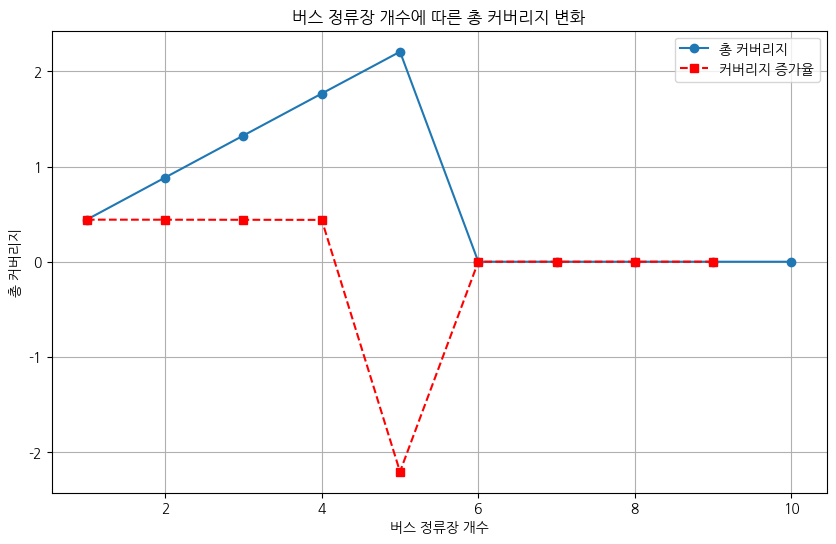

Bus Stops: 1 -> 2, Coverage Increase: 0.4423
Bus Stops: 2 -> 3, Coverage Increase: 0.4416
Bus Stops: 3 -> 4, Coverage Increase: 0.4409
Bus Stops: 4 -> 5, Coverage Increase: 0.4399
Bus Stops: 5 -> 6, Coverage Increase: -2.2078
Bus Stops: 6 -> 7, Coverage Increase: 0.0000
Bus Stops: 7 -> 8, Coverage Increase: 0.0000
Bus Stops: 8 -> 9, Coverage Increase: 0.0000
Bus Stops: 9 -> 10, Coverage Increase: 0.0000
[['원주중학교'], ['판부농협', '통일아파트'], ['판부농협', '원주중학교', '통일사거리'], ['롯데시네마', '청솔3차아파트', '장애인/노인종합복지관', '원주중학교'], ['프리미엄아울렛', '청솔4차아파트', '원주중학교', '통일사거리', 'KT강원본부'], [], [], [], [], []]


In [ ]:
optimize_bus_stops(df_단구동, coverage_radius=200, min_distance=400, facility_range=(1, 10))

### 무실동

Bus Stops: 1, Total Coverage: 0.4599
Bus Stops: 2, Total Coverage: 0.9033


<ipython-input-19-c325403d0c6b>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['인구밀집도_norm'] = normalize(df['인구밀집도'])
<ipython-input-19-c325403d0c6b>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['총_유동인구수_norm'] = normalize(df['총_유동인구수'])
<ipython-input-19-c325403d0c6b>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

Bus Stops: 3, Total Coverage: 1.3457
Bus Stops: 4, Total Coverage: 1.7867
Bus Stops: 5, Total Coverage: 2.2272
Bus Stops: 6, Total Coverage: 2.6671
Bus Stops: 7, No optimal solution found.
Bus Stops: 8, No optimal solution found.
Bus Stops: 9, No optimal solution found.
Bus Stops: 10, No optimal solution found.


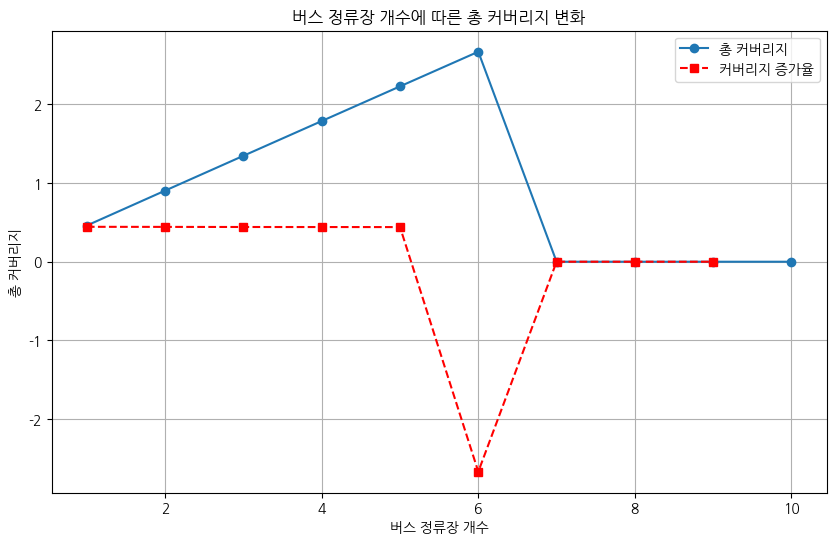

Bus Stops: 1 -> 2, Coverage Increase: 0.4435
Bus Stops: 2 -> 3, Coverage Increase: 0.4423
Bus Stops: 3 -> 4, Coverage Increase: 0.4411
Bus Stops: 4 -> 5, Coverage Increase: 0.4405
Bus Stops: 5 -> 6, Coverage Increase: 0.4399
Bus Stops: 6 -> 7, Coverage Increase: -2.6671
Bus Stops: 7 -> 8, Coverage Increase: 0.0000
Bus Stops: 8 -> 9, Coverage Increase: 0.0000
Bus Stops: 9 -> 10, Coverage Increase: 0.0000
[['이마트'], ['이마트', '로아노크사거리'], ['이마트', '원주시청', '새골'], ['이마트', '삼육초중고교', '법원', '원주시청(백운아트홀)'], ['원주역', '이마트', '대성고등학교', '원주시청(백운아트홀)', '새골'], ['이마트', '원주시청', '부영아파트사거리', '우미린아파트', '합포원', '박건호공원'], [], [], [], []]


In [ ]:
optimize_bus_stops(df_무실동, coverage_radius=200, min_distance=400, facility_range=(1, 10))

### 반곡관설동

<ipython-input-19-c325403d0c6b>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['인구밀집도_norm'] = normalize(df['인구밀집도'])
<ipython-input-19-c325403d0c6b>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['총_유동인구수_norm'] = normalize(df['총_유동인구수'])
<ipython-input-19-c325403d0c6b>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

Bus Stops: 1, Total Coverage: 0.4476
Bus Stops: 2, Total Coverage: 0.8928
Bus Stops: 3, Total Coverage: 1.3351
Bus Stops: 4, Total Coverage: 1.7769
Bus Stops: 5, Total Coverage: 2.2179
Bus Stops: 6, Total Coverage: 2.6581
Bus Stops: 7, Total Coverage: 3.0982
Bus Stops: 8, Total Coverage: 3.5379
Bus Stops: 9, Total Coverage: 3.9778
Bus Stops: 10, Total Coverage: 4.4179
Bus Stops: 11, No optimal solution found.
Bus Stops: 12, No optimal solution found.
Bus Stops: 13, No optimal solution found.
Bus Stops: 14, No optimal solution found.
Bus Stops: 15, No optimal solution found.
Bus Stops: 16, No optimal solution found.
Bus Stops: 17, No optimal solution found.
Bus Stops: 18, No optimal solution found.
Bus Stops: 19, No optimal solution found.
Bus Stops: 20, No optimal solution found.


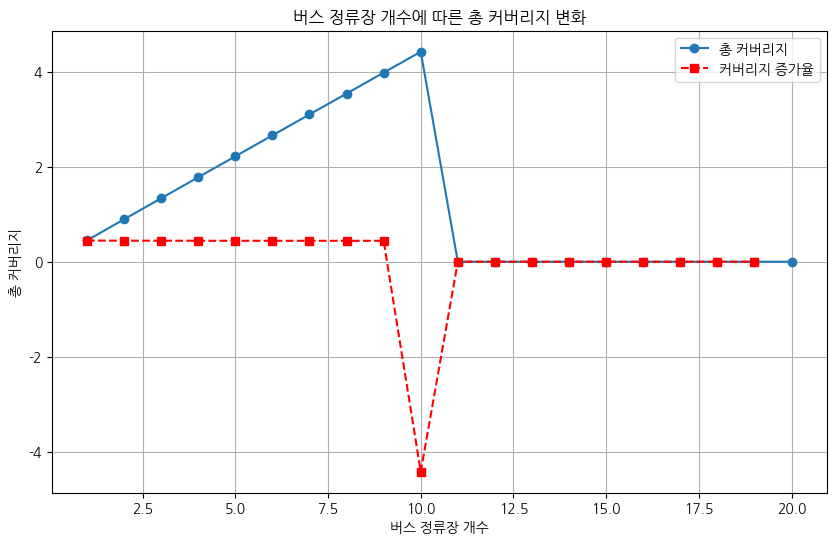

Bus Stops: 1 -> 2, Coverage Increase: 0.4452
Bus Stops: 2 -> 3, Coverage Increase: 0.4423
Bus Stops: 3 -> 4, Coverage Increase: 0.4418
Bus Stops: 4 -> 5, Coverage Increase: 0.4409
Bus Stops: 5 -> 6, Coverage Increase: 0.4402
Bus Stops: 6 -> 7, Coverage Increase: 0.4401
Bus Stops: 7 -> 8, Coverage Increase: 0.4397
Bus Stops: 8 -> 9, Coverage Increase: 0.4399
Bus Stops: 9 -> 10, Coverage Increase: 0.4401
Bus Stops: 10 -> 11, Coverage Increase: -4.4179
Bus Stops: 11 -> 12, Coverage Increase: 0.0000
Bus Stops: 12 -> 13, Coverage Increase: 0.0000
Bus Stops: 13 -> 14, Coverage Increase: 0.0000
Bus Stops: 14 -> 15, Coverage Increase: 0.0000
Bus Stops: 15 -> 16, Coverage Increase: 0.0000
Bus Stops: 16 -> 17, Coverage Increase: 0.0000
Bus Stops: 17 -> 18, Coverage Increase: 0.0000
Bus Stops: 18 -> 19, Coverage Increase: 0.0000
Bus Stops: 19 -> 20, Coverage Increase: 0.0000
[['관설동 종점'], ['관설동 종점', '푸른숨 휴브레스'], ['관설동 종점', '보배사거리', '영서고'], ['관설동 종점', '유만동', '도로교통공단', '영서고'], ['관설동 종점', '푸른숨LH3단지',

In [ ]:
optimize_bus_stops(df_반곡관설동, coverage_radius=200, min_distance=400, facility_range=(1, 20))

### 6개 읍면동 전체


In [ ]:
df['읍면동명'].value_counts()

,count
읍면동명,
반곡관설동,58
단구동,37
단계동,36
무실동,31
명륜동,23
개운동,14


Bus Stops: 1, Total Coverage: 0.2793
Bus Stops: 2, Total Coverage: 0.5575
Bus Stops: 3, Total Coverage: 0.8355
Bus Stops: 4, Total Coverage: 1.1133
Bus Stops: 5, Total Coverage: 1.3907
Bus Stops: 6, Total Coverage: 1.6675
Bus Stops: 7, Total Coverage: 1.8293
Bus Stops: 8, Total Coverage: 1.9908
Bus Stops: 9, Total Coverage: 2.1521
Bus Stops: 10, Total Coverage: 2.3133
Bus Stops: 11, Total Coverage: 2.4745
Bus Stops: 12, Total Coverage: 2.6356
Bus Stops: 13, Total Coverage: 2.7967
Bus Stops: 14, Total Coverage: 2.9578
Bus Stops: 15, Total Coverage: 3.1189
Bus Stops: 16, Total Coverage: 3.2800
Bus Stops: 17, No optimal solution found.
Bus Stops: 18, No optimal solution found.
Bus Stops: 19, No optimal solution found.
Bus Stops: 20, No optimal solution found.
Bus Stops: 21, No optimal solution found.
Bus Stops: 22, No optimal solution found.
Bus Stops: 23, No optimal solution found.
Bus Stops: 24, No optimal solution found.
Bus Stops: 25, No optimal solution found.
Bus Stops: 26, No optim

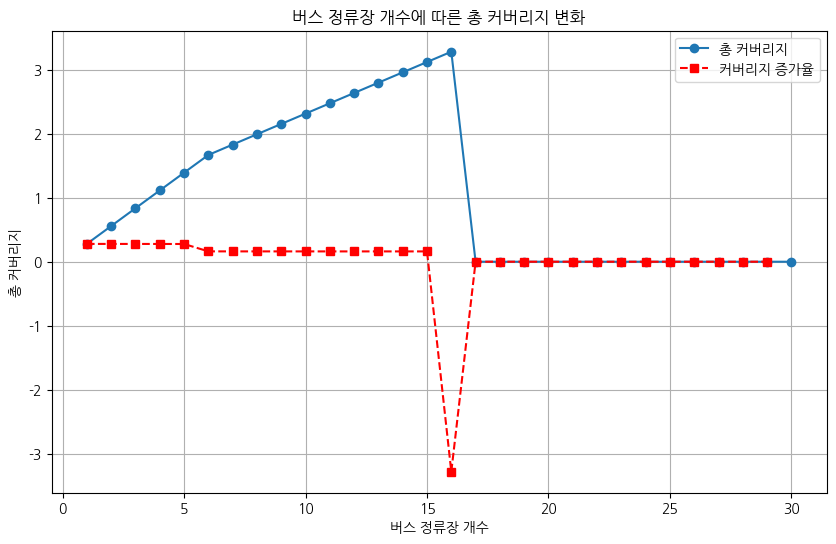

Bus Stops: 1 -> 2, Coverage Increase: 0.2782
Bus Stops: 2 -> 3, Coverage Increase: 0.2780
Bus Stops: 3 -> 4, Coverage Increase: 0.2778
Bus Stops: 4 -> 5, Coverage Increase: 0.2774
Bus Stops: 5 -> 6, Coverage Increase: 0.2769
Bus Stops: 6 -> 7, Coverage Increase: 0.1617
Bus Stops: 7 -> 8, Coverage Increase: 0.1615
Bus Stops: 8 -> 9, Coverage Increase: 0.1613
Bus Stops: 9 -> 10, Coverage Increase: 0.1612
Bus Stops: 10 -> 11, Coverage Increase: 0.1612
Bus Stops: 11 -> 12, Coverage Increase: 0.1611
Bus Stops: 12 -> 13, Coverage Increase: 0.1611
Bus Stops: 13 -> 14, Coverage Increase: 0.1611
Bus Stops: 14 -> 15, Coverage Increase: 0.1611
Bus Stops: 15 -> 16, Coverage Increase: 0.1611
Bus Stops: 16 -> 17, Coverage Increase: -3.2800
Bus Stops: 17 -> 18, Coverage Increase: 0.0000
Bus Stops: 18 -> 19, Coverage Increase: 0.0000
Bus Stops: 19 -> 20, Coverage Increase: 0.0000
Bus Stops: 20 -> 21, Coverage Increase: 0.0000
Bus Stops: 21 -> 22, Coverage Increase: 0.0000
Bus Stops: 22 -> 23, Coverage

In [ ]:
optimize_bus_stops(df, coverage_radius=200, min_distance=400, facility_range=(1,30))

In [ ]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp

# 가중치 정의
weights = {
    '인구밀집도': 0.5993,
    '유동인구수': 0.1774,
    '관광객방문수': 0.1031,
    '버스승하차': 0.1203
}

# 정규화 함수 정의
def normalize(series):
    min_val = series.min()
    max_val = series.max()
    if max_val != min_val:
        return (series - min_val) / (max_val - min_val)
    else:
        return pd.Series([0.5]*len(series), index=series.index)

# 최적의 버스 정류장을 선택하고 커버리지 변화를 시각화하는 함수
def optimize_bus_stops(df, coverage_radius=500, min_distance=1000, facility_range=(1, 10)):
    # 각 열을 정규화
    df['인구밀집도_norm'] = normalize(df['인구밀집도'])
    df['총_유동인구수_norm'] = normalize(df['총_유동인구수'])
    df['관광객방문수_norm'] = normalize(df['관광객방문수'])
    df['승하차수_norm'] = normalize(df['승하차수'])

    # 중요도 계산
    df['종합중요도'] = (
        weights['인구밀집도'] * df['인구밀집도_norm'] +
        weights['유동인구수'] * df['총_유동인구수_norm'] +
        weights['관광객방문수'] * df['관광객방문수_norm'] +
        weights['버스승하차'] * df['승하차수_norm']
    )

    # 중요도 기준으로 정렬
    df = df.sort_values(by='종합중요도', ascending=False).reset_index(drop=True)

    # 모든 정류장 간 거리 계산
    num_stations = len(df)
    distance_matrix = np.zeros((num_stations, num_stations))

    for i in range(num_stations):
        for j in range(num_stations):
            if i == j:
                distance_matrix[i][j] = 0
            else:
                coord1 = (df.loc[i, '위도'], df.loc[j, '경도'])
                coord2 = (df.loc[j, '위도'], df.loc[j, '경도'])
                distance = geodesic(coord1, coord2).meters
                distance_matrix[i][j] = distance

    # 커버리지 매트릭스 생성
    coverage_matrix = (distance_matrix <= coverage_radius).astype(int)

    # 겹치는 커버리지 방지
    overlap_pairs = []
    for i in range(num_stations):
        for j in range(i+1, num_stations):
            if distance_matrix[i][j] < min_distance:
                overlap_pairs.append((i, j))

    # 최적의 정류장 개수를 찾기 위한 범위 설정
    coverage_values = []
    selected_stations_list = []

    for num in range(facility_range[0], facility_range[1] + 1):
        # OR-Tools 선형 프로그래밍 솔버 초기화
        solver = pywraplp.Solver.CreateSolver('SCIP')
        if not solver:
            raise Exception("Solver not found.")

        # 변수 정의
        x = [solver.IntVar(0, 1, f'x_{i}') for i in range(num_stations)]

        # 목적 함수: 커버되는 수요의 최대화
        objective = solver.Objective()
        for j in range(num_stations):
            for i in range(num_stations):
                if coverage_matrix[i][j]:
                    objective.SetCoefficient(x[i], df.loc[j, '종합중요도'])
        objective.SetMaximization()

        # 제약 조건 1: 선택할 정류장 수는 num
        solver.Add(solver.Sum(x) == num)

        # 제약 조건 2: 커버리지 영역 겹치지 않도록 최소 거리 유지
        for (i, j) in overlap_pairs:
            solver.Add(x[i] + x[j] <= 1)

        # 문제 해결
        status = solver.Solve()

        if status == pywraplp.Solver.OPTIMAL:
            coverage = objective.Value()
            coverage_values.append(coverage)
            current_selected_stations = []
            for i in range(num_stations):
                if x[i].solution_value() > 0.5:
                    current_selected_stations.append(df.loc[i, '버스정류장명'])
            selected_stations_list.append(current_selected_stations)
            print(f'Bus Stops: {num}, Total Coverage: {coverage:.4f}')
        else:
            coverage_values.append(0)
            selected_stations_list.append([])
            print(f'Bus Stops: {num}, No optimal solution found.')

    # 커버리지 변화 시각화
    plt.figure(figsize=(10,6))
    plt.plot(range(facility_range[0], facility_range[1] + 1), coverage_values, marker='o', label='총 커버리지')
    plt.xlabel('버스 정류장 개수')
    plt.ylabel('총 커버리지')
    plt.title('버스 정류장 개수에 따른 총 커버리지 변화')
    plt.grid(True)

    # 기울기(증가율) 계산
    coverage_diffs = np.diff(coverage_values)
    plt.plot(range(facility_range[0], facility_range[1]), coverage_diffs, marker='s', linestyle='--', color='red', label='커버리지 증가율')
    plt.legend()
    plt.show()

    # 기울기 출력
    for num, diff in zip(range(facility_range[0], facility_range[1]), coverage_diffs):
        print(f'Bus Stops: {num} -> {num+1}, Coverage Increase: {diff:.4f}')

    # 엘보우 기법으로 최적의 버스 정류장 개수 선택
    optimal_num_facilities = np.argmax(coverage_diffs) + 1  # 기울기 차이가 큰 곳을 최적 개수로 설정
    print(f"\n최적의 버스 정류장 개수: {optimal_num_facilities}")

    # 최적의 버스 정류장명 출력
    optimal_stations = selected_stations_list[optimal_num_facilities - 1]  # 인덱스는 0부터 시작하므로 -1
    print("\n선택된 최적의 버스 정류장:")
    for station in optimal_stations:
        print(f"- {station}")

    return optimal_stations

# 함수 호출 예시
# 최적의 버스 정류장 개수 및 선택된 정류장 출력
# optimal_stations = optimize_bus_stops(df, coverage_radius=500, min_distance=1000, facility_range=(1, 10))


## 정류장 목록이 확실하지 않은것같아서 노가다로 다시 확인

### df명 바꿔서 확인해보셈. 이거는 목록만 빼는거임. ㄷ다른 시각화는 참고 ㄴㄴ 위에참고하셈

In [ ]:
df = df_반곡관설동

In [ ]:
# 가중치 정의
weights = {
    '인구밀집도': 0.5993,
    '유동인구수': 0.1774,
    '관광객방문수': 0.1031,
    '버스승하차': 0.1203
}

# 정규화 함수 정의
def normalize(series):
    min_val = series.min()
    max_val = series.max()
    if max_val != min_val:
        return (series - min_val) / (max_val - min_val)
    else:
        return pd.Series([0.5]*len(series), index=series.index)

# 각 열을 정규화 (0~1 범위로 스케일링)
df['인구밀집도_norm'] = normalize(df['인구밀집도'])
df['총_유동인구수_norm'] = normalize(df['총_유동인구수'])
df['관광객방문수_norm'] = normalize(df['관광객방문수'])
df['승하차수_norm'] = normalize(df['승하차수'])

# 중요도 계산
df['종합중요도'] = (
    weights['인구밀집도'] * df['인구밀집도_norm'] +
    weights['유동인구수'] * df['총_유동인구수_norm'] +
    weights['관광객방문수'] * df['관광객방문수_norm'] +
    weights['버스승하차'] * df['승하차수_norm']
)

# 중요도 기준으로 정렬
df = df.sort_values(by='종합중요도', ascending=False).reset_index(drop=True)

# 중요도 확인
print(df[['버스정류장명', '종합중요도']])

           버스정류장명     종합중요도
0          관설동 종점  0.560200
1          대한적십자사  0.551963
2            근린공원  0.515409
3       건강보험심사평가원  0.506142
4           힐데스하임  0.500479
5          치악고등학교  0.500479
6            원주여고  0.497390
7       청솔6.8차아파트  0.483833
8       푸른숨LH10단지  0.482117
9        푸른숨 휴브레스  0.479542
10        노인종합복지관  0.474051
11        원주보훈요양원  0.471477
12        현진4차아파트  0.469760
13  미래삼거리(센트럴파크6)  0.468388
14         당둔지승강장  0.463582
15         봉대초등학교  0.460837
16       국민건강보험공단  0.459979
17            유만동  0.457576
18         아이파크후문  0.456718
19       반곡아이파크후문  0.456375
20       푸른숨LH3단지  0.456203
21          반곡중학교  0.455345
22       벽산블루밍아파트  0.454830
23         도로교통공단  0.453114
24         영서고등학교  0.452943
25       푸른숨LH9단지  0.451570
26          중흥2단지  0.451570
27           메가박스  0.450368
28        청솔5차아파트  0.449510
29      원주자동차운전학원  0.447623
30         반곡아이파크  0.447451
31            학마을  0.447279
32          코아루시티  0.446078
33       한국광해광업공단  0.445906
34          보배사거리  0

<ipython-input-75-dbadff522319>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['인구밀집도_norm'] = normalize(df['인구밀집도'])
<ipython-input-75-dbadff522319>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['총_유동인구수_norm'] = normalize(df['총_유동인구수'])
<ipython-input-75-dbadff522319>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

In [ ]:
# 커버리지 반경 설정 (단위: 미터)
coverage_radius = 200  # 예: 200미터

# 최소 거리 설정 (커버리지 영역이 겹치지 않도록)
min_distance = 2 * coverage_radius  # 400미터

# 최적화할 시설 수 설정 (추후 최적 개수 찾기)
num_facilities = 22

# 모든 정류장 간 거리 계산
num_stations = len(df)
distance_matrix = np.zeros((num_stations, num_stations))

for i in range(num_stations):
    for j in range(num_stations):
        if i == j:
            distance_matrix[i][j] = 0
        else:
            coord1 = (df.loc[i, '위도'], df.loc[i, '경도'])
            coord2 = (df.loc[j, '위도'], df.loc[j, '경도'])
            distance = geodesic(coord1, coord2).meters
            distance_matrix[i][j] = distance

# 커버리지 매트릭스 생성 (1: 커버, 0: 미커버)
coverage_matrix = (distance_matrix <= coverage_radius).astype(int)

# 겹치는 커버리지 방지: 정류장 간 최소 거리 준수
# 겹칠 수 있는 정류장 쌍 찾기 (거리가 min_distance 미만)
overlap_pairs = []
for i in range(num_stations):
    for j in range(i+1, num_stations):
        if distance_matrix[i][j] < min_distance:
            overlap_pairs.append((i, j))

print(f"Total overlap pairs: {len(overlap_pairs)}")

Total overlap pairs: 82


In [ ]:
# OR-Tools 선형 프로그래밍 솔버 초기화
solver = pywraplp.Solver.CreateSolver('SCIP')

if not solver:
    raise Exception("Solver not found.")

# 변수: 각 정류장이 선택되었는지 여부 (0 또는 1)
x = [solver.IntVar(0, 1, f'x_{i}') for i in range(num_stations)]

# 목적 함수: 커버되는 수요의 최대화
objective = solver.Objective()
for j in range(num_stations):
    for i in range(num_stations):
        if coverage_matrix[i][j]:
            objective.SetCoefficient(x[i], df.loc[j, '종합중요도'])
objective.SetMaximization()

# 제약 조건 1: 선택할 정류장 수는 num_facilities
solver.Add(solver.Sum(x) == num_facilities)

# 제약 조건 2: 커버리지 영역 겹치지 않도록 최소 거리 유지
for (i, j) in overlap_pairs:
    solver.Add(x[i] + x[j] <= 1)

# 문제 해결
status = solver.Solve()

if status == pywraplp.Solver.OPTIMAL:
    print(f'Optimal solution found with total coverage: {objective.Value():.4f}')
    selected_stations = []
    for i in range(num_stations):
        if x[i].solution_value() > 0.5:
            selected_stations.append(df.loc[i, '버스정류장명'])
            print(f'선택된 정류장 {i}: {df.loc[i, "버스정류장명"]}')
else:
    print("No optimal solution found.")

Optimal solution found with total coverage: 10.2046
선택된 정류장 0: 관설동 종점
선택된 정류장 2: 근린공원
선택된 정류장 3: 건강보험심사평가원
선택된 정류장 4: 힐데스하임
선택된 정류장 8: 푸른숨LH10단지
선택된 정류장 10: 노인종합복지관
선택된 정류장 11: 원주보훈요양원
선택된 정류장 14: 당둔지승강장
선택된 정류장 15: 봉대초등학교
선택된 정류장 17: 유만동
선택된 정류장 21: 반곡중학교
선택된 정류장 22: 벽산블루밍아파트
선택된 정류장 23: 도로교통공단
선택된 정류장 27: 메가박스
선택된 정류장 28: 청솔5차아파트
선택된 정류장 30: 반곡아이파크
선택된 정류장 33: 한국광해광업공단
선택된 정류장 37: 영서고
선택된 정류장 39: 관설동화훼단지
선택된 정류장 46: 마가렛보호작업장
선택된 정류장 48: 섭재둔덕
선택된 정류장 50: 국립과학수사연구원


Bus Stops: 1, Total Coverage: 0.5602
Bus Stops: 2, Total Coverage: 1.0756
Bus Stops: 3, Total Coverage: 1.5818
Bus Stops: 4, Total Coverage: 2.0639
Bus Stops: 5, Total Coverage: 2.5434
Bus Stops: 6, Total Coverage: 3.0175
Bus Stops: 7, Total Coverage: 3.4889
Bus Stops: 8, Total Coverage: 3.9498
Bus Stops: 9, Total Coverage: 4.4074
Bus Stops: 10, Total Coverage: 4.8627
Bus Stops: 11, Total Coverage: 5.3175
Bus Stops: 12, Total Coverage: 5.7679
Bus Stops: 13, Total Coverage: 6.2174
Bus Stops: 14, Total Coverage: 6.6649
Bus Stops: 15, Total Coverage: 7.1108
Bus Stops: 16, Total Coverage: 7.5555
Bus Stops: 17, Total Coverage: 7.9993
Bus Stops: 18, Total Coverage: 8.4416
Bus Stops: 19, Total Coverage: 8.8834
Bus Stops: 20, Total Coverage: 9.3245
Bus Stops: 21, Total Coverage: 9.7646
Bus Stops: 22, Total Coverage: 10.2046
Bus Stops: 23, Total Coverage: 10.6445
Bus Stops: 24, Total Coverage: 11.0699
Bus Stops: 25, No optimal solution found.
Bus Stops: 26, No optimal solution found.
Bus Stops:

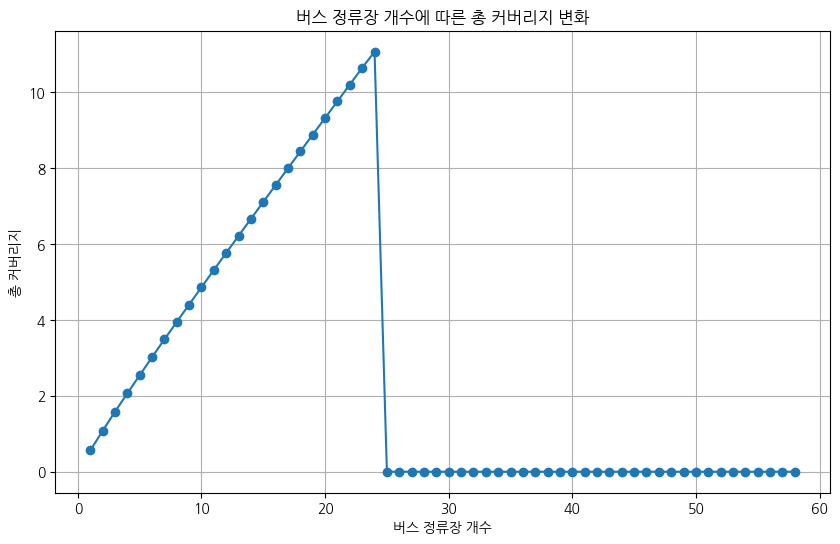

In [ ]:
# 최적의 정류장 개수를 찾기 위한 범위 설정
facility_range = range(1, min(60, num_stations) + 1)  # 1개부터 10개까지 시도 (필요에 따라 조정)
coverage_values = []
selected_stations_list = []

for num in facility_range:
    # OR-Tools 선형 프로그래밍 솔버 초기화
    solver = pywraplp.Solver.CreateSolver('SCIP')

    if not solver:
        raise Exception("Solver not found.")

    # 변수: 각 정류장이 선택되었는지 여부 (0 또는 1)
    x = [solver.IntVar(0, 1, f'x_{i}') for i in range(num_stations)]

    # 목적 함수: 커버되는 수요의 최대화
    objective = solver.Objective()
    for j in range(num_stations):
        for i in range(num_stations):
            if coverage_matrix[i][j]:
                objective.SetCoefficient(x[i], df.loc[j, '종합중요도'])
    objective.SetMaximization()

    # 제약 조건 1: 선택할 정류장 수는 num
    solver.Add(solver.Sum(x) == num)

    # 제약 조건 2: 커버리지 영역 겹치지 않도록 최소 거리 유지
    for (i, j) in overlap_pairs:
        solver.Add(x[i] + x[j] <= 1)

    # 문제 해결
    status = solver.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        coverage = objective.Value()
        coverage_values.append(coverage)
        current_selected_stations = []
        for i in range(num_stations):
            if x[i].solution_value() > 0.5:
                current_selected_stations.append(df.loc[i, '버스정류장명'])
        selected_stations_list.append(current_selected_stations)
        print(f'Bus Stops: {num}, Total Coverage: {coverage:.4f}')
    else:
        coverage_values.append(0)
        selected_stations_list.append([])
        print(f'Bus Stops: {num}, No optimal solution found.')

# 커버리지 변화 시각화
plt.figure(figsize=(10,6))
plt.plot(facility_range, coverage_values, marker='o')
plt.xlabel('버스 정류장 개수')
plt.ylabel('총 커버리지')
plt.title('버스 정류장 개수에 따른 총 커버리지 변화')
plt.grid(True)
plt.show()

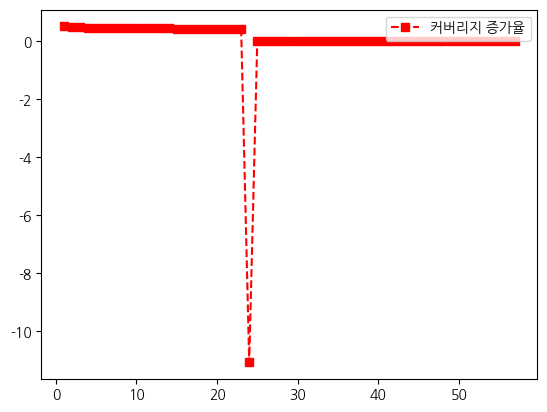

Bus Stops: 1 -> 2, Coverage Increase: 0.5154
Bus Stops: 2 -> 3, Coverage Increase: 0.5061
Bus Stops: 3 -> 4, Coverage Increase: 0.4821
Bus Stops: 4 -> 5, Coverage Increase: 0.4795
Bus Stops: 5 -> 6, Coverage Increase: 0.4741
Bus Stops: 6 -> 7, Coverage Increase: 0.4715
Bus Stops: 7 -> 8, Coverage Increase: 0.4608
Bus Stops: 8 -> 9, Coverage Increase: 0.4576
Bus Stops: 9 -> 10, Coverage Increase: 0.4553
Bus Stops: 10 -> 11, Coverage Increase: 0.4548
Bus Stops: 11 -> 12, Coverage Increase: 0.4504
Bus Stops: 12 -> 13, Coverage Increase: 0.4495
Bus Stops: 13 -> 14, Coverage Increase: 0.4475
Bus Stops: 14 -> 15, Coverage Increase: 0.4459
Bus Stops: 15 -> 16, Coverage Increase: 0.4447
Bus Stops: 16 -> 17, Coverage Increase: 0.4438
Bus Stops: 17 -> 18, Coverage Increase: 0.4423
Bus Stops: 18 -> 19, Coverage Increase: 0.4418
Bus Stops: 19 -> 20, Coverage Increase: 0.4411
Bus Stops: 20 -> 21, Coverage Increase: 0.4401
Bus Stops: 21 -> 22, Coverage Increase: 0.4401
Bus Stops: 22 -> 23, Coverage 

In [ ]:
# 기울기(증가율) 계산
coverage_diffs = np.diff(coverage_values)
slope = coverage_diffs / 1  # 버스 정류장 개수 간 간격이 1이므로 단순히 차이

# 기울기 시각화 (같은 x 축에, shifted x)
plt.plot(facility_range[:-1], coverage_diffs, marker='s', linestyle='--', color='red', label='커버리지 증가율')
plt.legend()
plt.show()

# 기울기 출력
for num, diff in zip(facility_range[:-1], coverage_diffs):
    print(f'Bus Stops: {num} -> {num+1}, Coverage Increase: {diff:.4f}')

In [ ]:
# 최적의 정류장 개수 선택 (엘보우 지점에 따라 설정)
# 예시로, facility_range 중 최대 커버리지를 제공하는 개수를 선택
# 실제 데이터에서는 엘보우 지점을 시각화한 그래프를 보고 선택하세요
optimal_num_facilities = 10  # 3개로 설정

# 선택된 정류장 목록
selected_stations = selected_stations_list[facility_range.index(optimal_num_facilities)]

print(f'\nOptimal number of bus stops: {optimal_num_facilities}')
print('Selected Bus Stops:')
for station in selected_stations:
    print(f'- {station}')

# 지도 중심 설정 (데이터의 평균 위도와 경도)
center_lat = df['위도'].mean()
center_lon = df['경도'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# 모든 정류장 표시 (파란색 마커)
for idx, row in df.iterrows():
    folium.CircleMarker(
        location=[row['위도'], row['경도']],
        radius=5,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        popup=row['버스정류장명']
    ).add_to(m)

# 선택된 정류장 표시 (빨간색 마커) 및 커버리지 반경 표시 (동그라미)
for station in selected_stations:
    row = df[df['버스정류장명'] == station].iloc[0]

    # 선택된 정류장 마커 (빨간색)
#    folium.Marker(
#        location=[row['위도'], row['경도']],
#        popup=f"{row['버스정류장명']}<br>종합중요도: {row['종합중요도']:.4f}",
#        icon=folium.Icon(color='red', icon='info-sign')
#    ).add_to(m)

    # 커버리지 반경 표시 (동그라미)
    folium.Circle(
        location=[row['위도'], row['경도']],
        radius=coverage_radius,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.1
    ).add_to(m)

# 지도 저장 및 표시
m.save('selected_bus_stations.html')
m  # Jupyter Notebook에서 지도를 직접 표시
print("\n선택된 정류장이 표시된 지도가 'selected_bus_stations.html'로 저장되었습니다.")


Optimal number of bus stops: 10
Selected Bus Stops:
- 관설동 종점
- 대한적십자사
- 근린공원
- 힐데스하임
- 푸른숨LH10단지
- 노인종합복지관
- 원주보훈요양원
- 봉대초등학교
- 유만동
- 반곡중학교

선택된 정류장이 표시된 지도가 'selected_bus_stations.html'로 저장되었습니다.
